## ERA5 climate data

In [ ]:
pip install gcsfs

In [ ]:
pip install xarray_spatial

In [1]:
import xrspatial

/env/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


In [2]:
from xrspatial import hillshade

In [3]:
import xarray
import odc.geo.xr
from odc.geo.geom import BoundingBox


def load_era5(
    x=None,
    y=None,
    crs="EPSG:4326",
    time=None,  #("2020-01-01 1:00", "2020-01-01 10:00"),
    bands=None,
    path="gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3",
):
    # Lazily load Zarr from Google Cloud Platform
    era5_ds = xarray.open_zarr(path, chunks=None, storage_options=dict(token="anon"))

    # Select bands
    era5_ds = era5_ds[bands] if bands is not None else era5_ds

    # Clip to extent
    if x is not None:
        bbox = BoundingBox.from_xy(x, y, crs=crs).to_crs("EPSG:4326")
        era5_ds = era5_ds.sel(
            longitude=slice(bbox.left, bbox.right),
            latitude=slice(bbox.top, bbox.bottom),
        )
        
    # Select time
    if time is not None:
        era5_ds = era5_ds.sel(time=slice(time[0], time[-1]))

    return era5_ds.odc.assign_crs("EPSG:4326")

In [ ]:
# # Lazily load Zarr from Google Cloud Platform
# era5_ds = xarray.open_zarr(
#     "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3",
#     chunks=None,
#     storage_options=dict(token="anon"),


### Snow animation

In [4]:
from dea_tools.dask import create_local_dask_cluster

client = create_local_dask_cluster(return_client=True)

<Client: 'tcp://127.0.0.1:42351' processes=1 threads=94, memory=697.21 GiB>

In [5]:
import datacube
from dea_tools.datahandling import load_ard
from datacube.utils.masking import mask_invalid_data

dc = datacube.Datacube()

# t, l = -36.25, 148.17
# b, r = -36.52, 148.53
t, l = -36.076, 148.20
b, r = -36.57, 148.4847


query_params = dict(
    x=(l, r),
    y=(t, b),
    time=("1988", "2024"),
    cloud_cover=(0, 90),
)

load_params = dict(
    measurements=["red", "green", "blue"],
    group_by="solar_day",
    # resolution=(-30, 30),
    dask_chunks={},
)

ds = load_ard(
    dc=dc,
    products=[
        "ga_ls5t_ard_3",
        "ga_ls7e_ard_3",
        "ga_ls8c_ard_3",
        "ga_ls9c_ard_3",
    ],
    mask_pixel_quality=False,
    dtype="float",
    ls7_slc_off=False,
    **query_params,
    **load_params,
)

Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls8c_ard_3
    ga_ls9c_ard_3
Returning 1373 time steps as a dask array


/env/lib/python3.10/site-packages/odc/geo/_rgba.py:55: RuntimeWarning: invalid value encountered in cast
  return x.astype("uint8")


<xarray.Dataset> Size: 68GB
Dimensions:      (time: 1373, y: 1920, x: 1080)
Coordinates:
  * time         (time) datetime64[ns] 11kB 1988-01-08T23:19:38.595405 ... 20...
  * y            (y) float64 15kB -4.034e+06 -4.034e+06 ... -4.092e+06
  * x            (x) float64 9kB 1.449e+06 1.449e+06 ... 1.481e+06 1.481e+06
    spatial_ref  int32 4B 3577
Data variables:
    red          (time, y, x) float64 23GB dask.array<chunksize=(1, 1920, 1080), meta=np.ndarray>
    green        (time, y, x) float64 23GB dask.array<chunksize=(1, 1920, 1080), meta=np.ndarray>
    blue         (time, y, x) float64 23GB dask.array<chunksize=(1, 1920, 1080), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


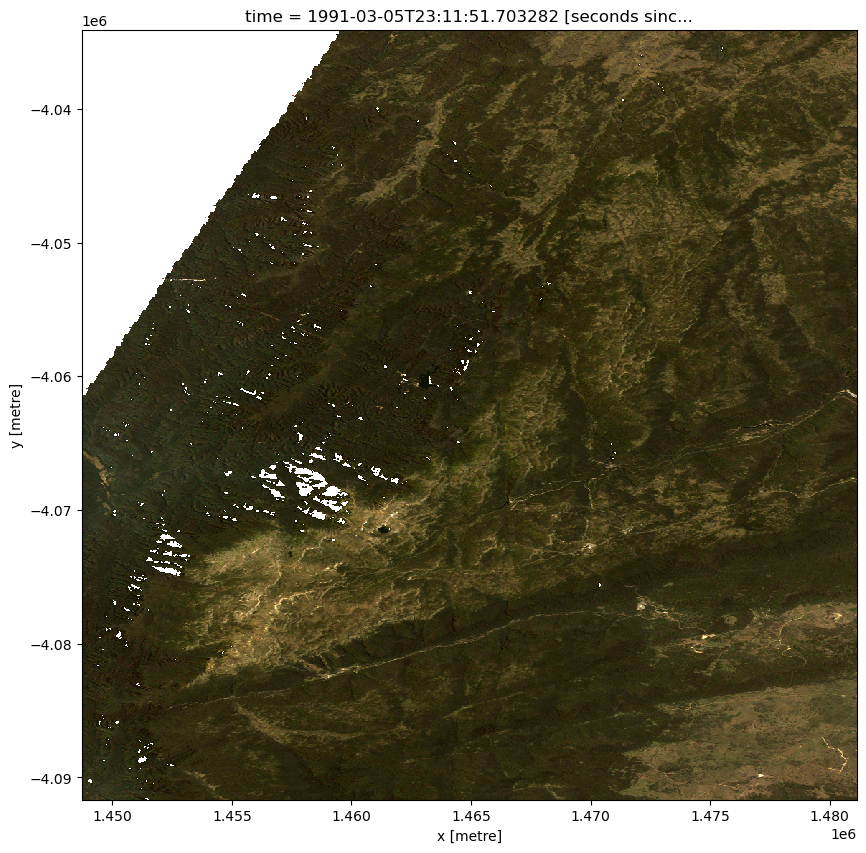

In [6]:
# ds = mask_invalid_data(ds)
ds.isel(time=105).odc.to_rgba(vmin=0, vmax=2000).plot.imshow(aspect=1, size=10)
print(ds)

In [7]:
era5_ds = load_era5(
    x=(l, r),
    y=(t, b),
    bands=["total_cloud_cover"],
)

era5_ds

<xarray.Dataset> Size: 17MB
Dimensions:            (time: 1089864, latitude: 2, longitude: 1)
Coordinates:
  * latitude           (latitude) float32 8B -36.25 -36.5
  * longitude          (longitude) float32 4B 148.2
  * time               (time) datetime64[ns] 9MB 1900-01-01 ... 2024-04-30T23...
    spatial_ref        int32 4B 4326
Data variables:
    total_cloud_cover  (time, latitude, longitude) float32 9MB ...

In [8]:
era5_cloud = era5_ds.sel(time=ds.time, method="nearest").total_cloud_cover.mean(dim=["latitude", "longitude"])

In [9]:
ds_subset = ds.isel(time = era5_cloud.values < 0.25)

In [10]:
ds_rolling = ds_subset.rolling(time=21, min_periods=1).median(dim=["time"])
ds_rolling.load()

/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2024-07-09 06:56:36,619 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 573.36 GiB -- Worker memory limit: 697.21 GiB
2024-07-09 06:56:44,003 - distributed.worker.memory - WARNING - Worker is at 76% memory usage. Resuming worker. Process memory: 530.07 GiB -- Worker memory limit: 697.21 GiB
2024-07-09 06:57:27,939 - distributed.worker.memory - WARNING - gc.collect() took 1.091s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2024-07-09 06:57:27,939 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 560.14 GiB -- Worker memory limit: 697.21 GiB
2024-07-09 06:57:32,859 - distributed.worker.memory - WARNING - Worker i

<xarray.Dataset> Size: 25GB
Dimensions:      (time: 496, y: 1920, x: 1080)
Coordinates:
  * time         (time) datetime64[ns] 4kB 1988-01-08T23:19:38.595405 ... 202...
  * y            (y) float64 15kB -4.034e+06 -4.034e+06 ... -4.092e+06
  * x            (x) float64 9kB 1.449e+06 1.449e+06 ... 1.481e+06 1.481e+06
    spatial_ref  int32 4B 3577
Data variables:
    red          (time, y, x) float64 8GB nan nan nan nan ... 268.0 320.0 342.0
    green        (time, y, x) float64 8GB nan nan nan nan ... 260.0 306.0 321.0
    blue         (time, y, x) float64 8GB nan nan nan nan ... 123.0 157.0 166.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [11]:
dem = dc.load(
    product="ga_srtm_dem1sv1_0",
    like=ds.odc.geobox,
    resampling="bilinear",
    measurements=["dem_s"],
).squeeze()

Applying custom image processing functions


  0%|          | 0/486 (0.0 seconds remaining at ? frames/s)

Exporting animation to animation.mp4


  0%|          | 0/486 (0.0 seconds remaining at ? frames/s)

/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


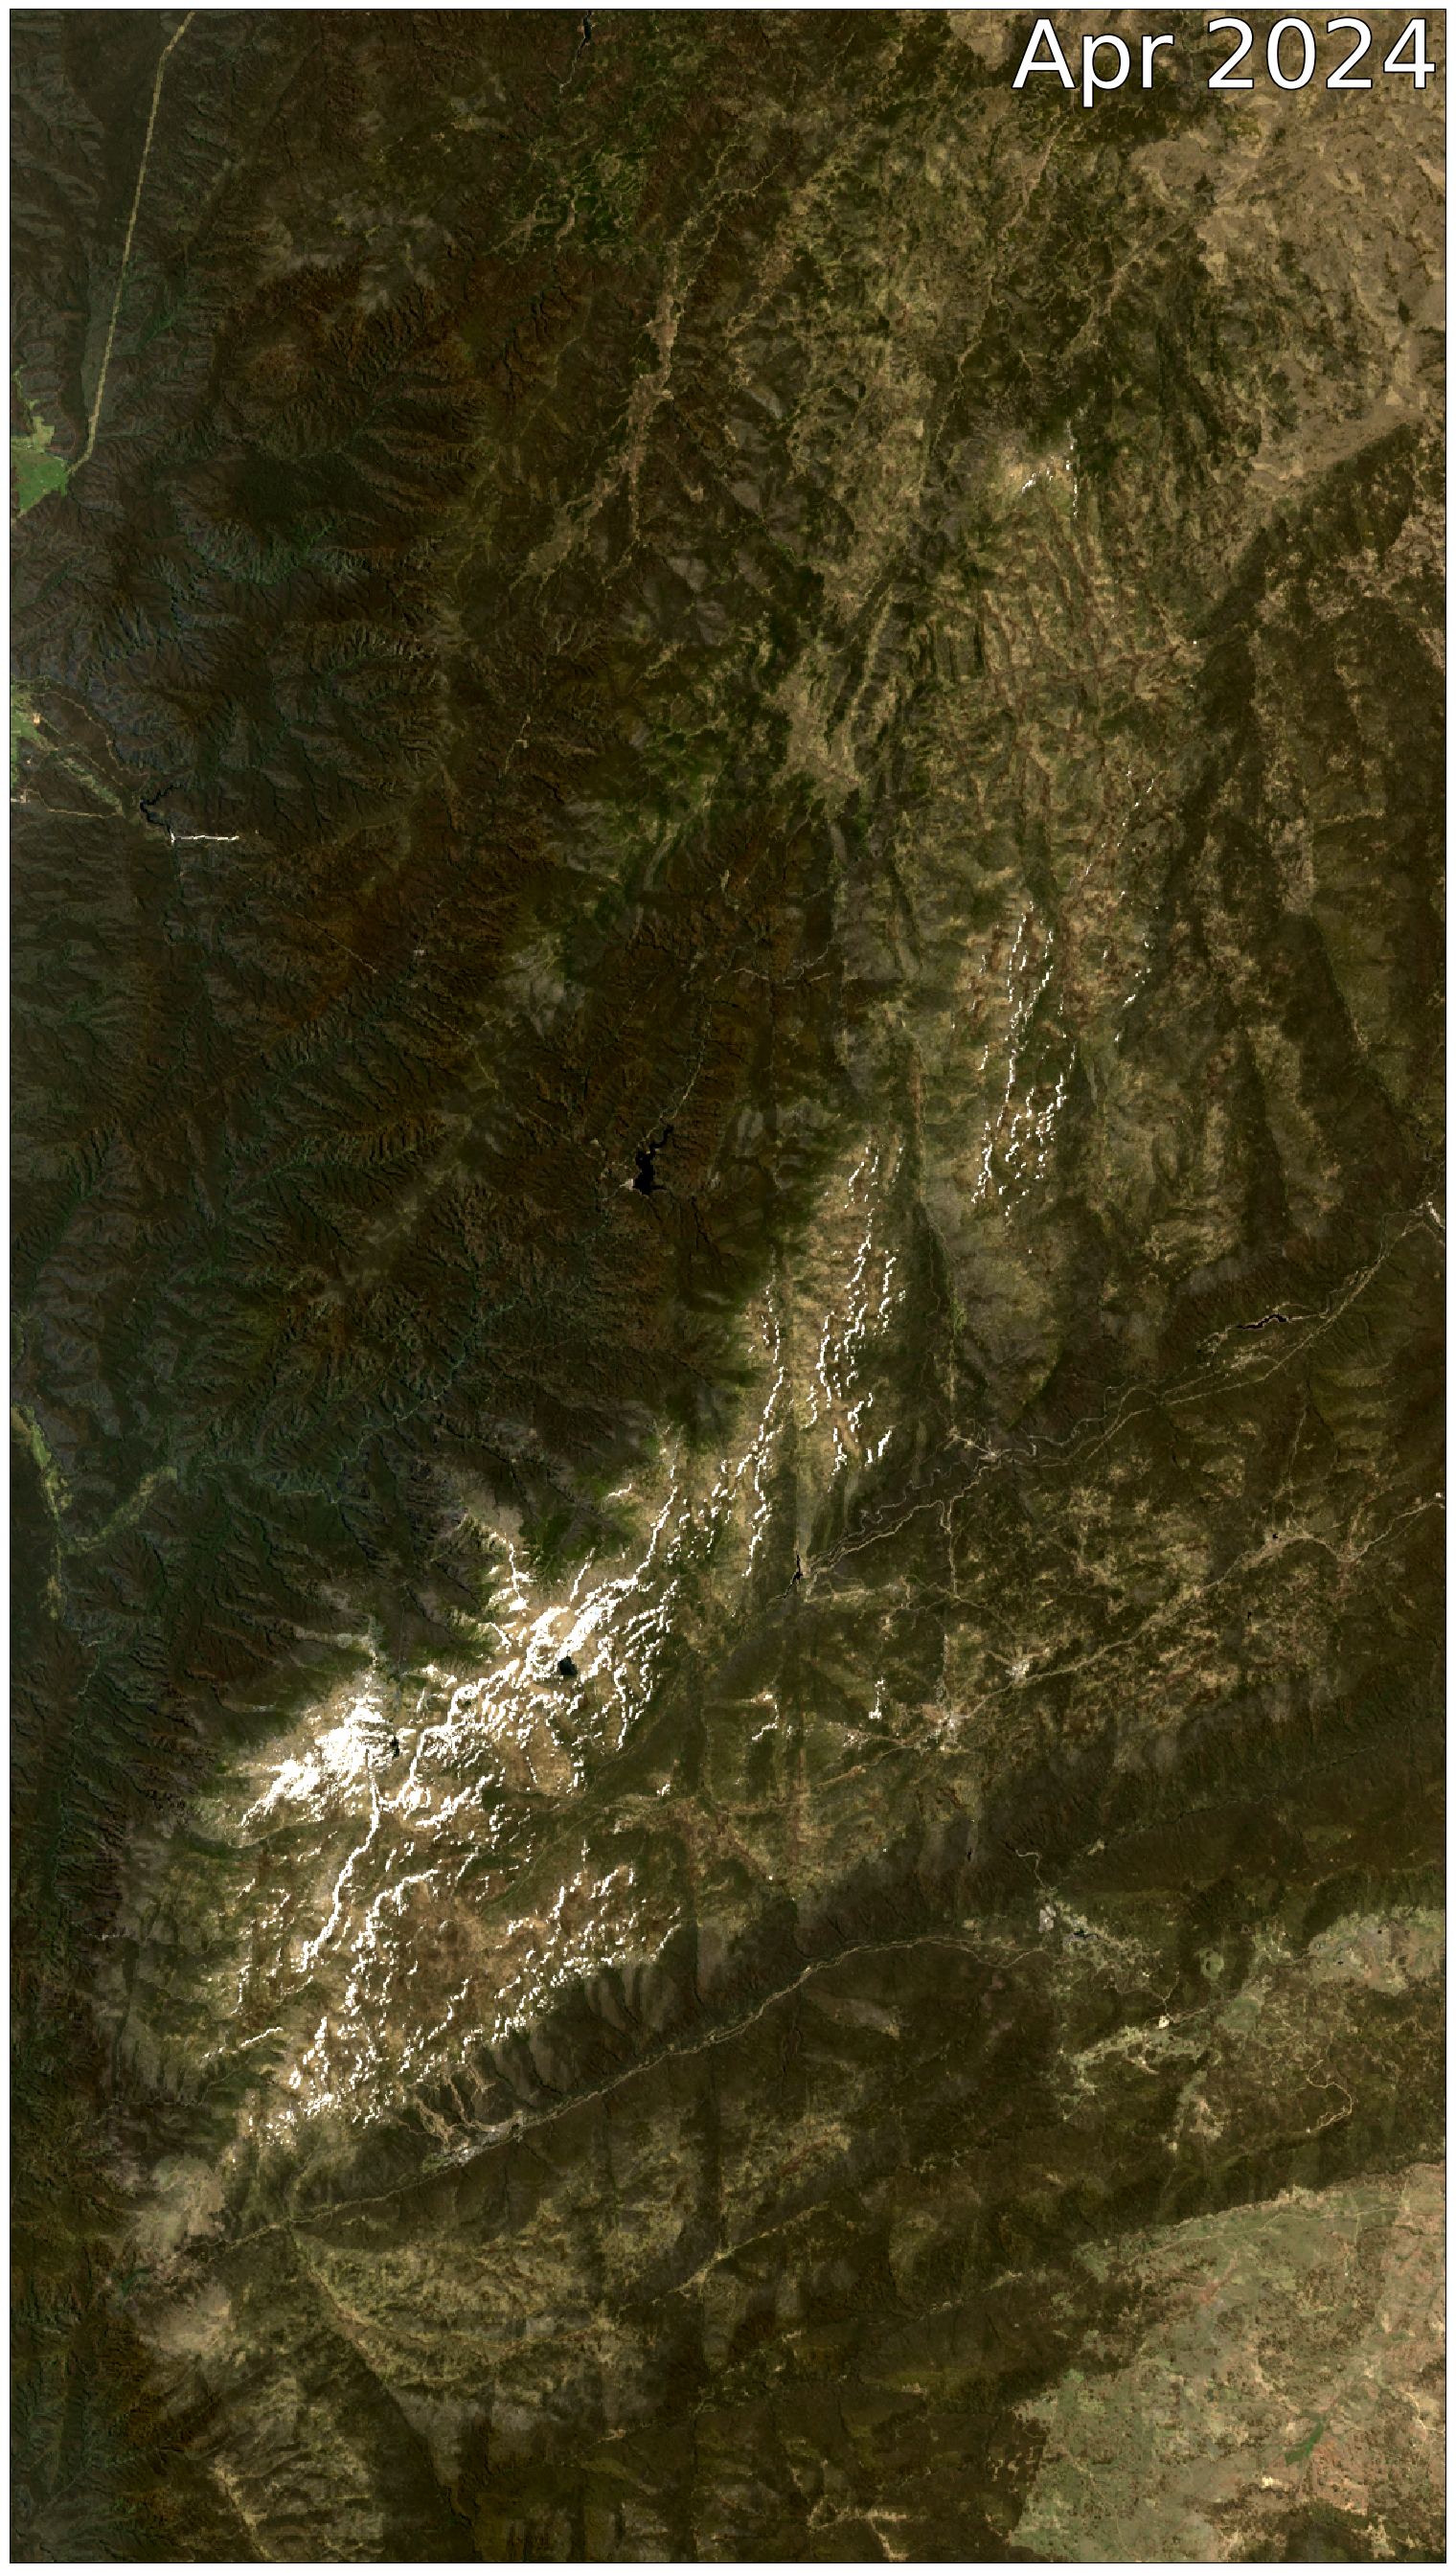

In [13]:
from dea_tools.plotting import xr_animation

xr_animation(
    ds_rolling.isel(time=slice(10, None)) * hillshade(dem.dem_s).clip(0.7, 1),
    output_path='animation.mp4',
    bands=["red", "green", "blue"],
    percentile_stretch=(0.02, 0.98),
    width_pixels=1080,
    interval=30,
    show_date="%b %Y",
    annotation_kwargs={'fontsize': 70},
    # limit=5,
    image_proc_funcs={lambda x: x**0.6},
)

In [ ]:
.odc.to_rgba(vmin=0, vmax=1500).plot.imshow()

In [ ]:
# from dea_tools.spatial import hillshade
hillshade(dem.dem_s).plot.imshow()

In [ ]:
# hillshade(dem=dem.dem_s.values, elevation=45, azimuth=315)

In [ ]:
# test.isel(time=55).odc.to_rgba(vmin=50, vmax=2000).plot.imshow(robust=True, size=10)

In [ ]:
ds.red.isel(time = era5_cloud.values > 0.9).median(dim=["time"]).plot.imshow()

In [ ]:
from dea_tools.plotting import xr_animation
import odc.geo.xr

band = "significant_height_of_combined_wind_waves_and_swell"
da = era5_ds  #.isel(time=slice(0, -1, 2))

xr_animation(da, bands=[band], width_pixels=1000, interval=20, imshow_kwargs=dict(cmap="inferno"), colorbar_kwargs={'colors': 'black'})    #.plot.imshow(col="time", robust=True)

In [ ]:
# era5_ds.isel(time=0).plot()

In [ ]:
era5_ds

In [ ]:
y_4326

In [ ]:
ar_full_37_1h = xarray.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    # "gs://gcp-public-data-arco-era5/ar/1959-2022-full_37-1h-0p25deg-chunk-1.zarr-v2",
    chunks=None,
    storage_options=dict(token='anon'),
)

In [ ]:
# ar_full_37_1h.data_vars

In [ ]:
# ar_full_37_1h_2 = xarray.open_zarr(
#     # 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
#     "gs://gcp-public-data-arco-era5/ar/1959-2022-full_37-1h-0p25deg-chunk-1.zarr-v2",
#     chunks=None,
#     storage_options=dict(token='anon'),
# )

In [ ]:
# ar_full_37_1h  #.total_precipitation.sel(time="1988-01-01 18:00").plot()

In [ ]:
# ar_full_37_1h_2.total_precipitation.sel(time="2020-01-01 12:00").plot()

In [ ]:
# ar_full_37_1h.significant_height_of_combined_wind_waves_and_swell.sel(time="2020-01-01 12:00").plot()

In [ ]:
ar_full_37_1h_1

In [ ]:
ar_full_37_1h_2

In [ ]:
import cmocean

In [ ]:
ar_full_37_1h.isel(time=slice(200000, 200200))["total_cloud_cover"].plot.hist()

In [ ]:
import gcsfs

In [ ]:
xarray.open_zarr(
    'gs://gcp-public-data-arco-era5/co/single-level-reanalysis.zarr-v2',
    chunks=None,
    storage_options=dict(token='anon'),
)

In [ ]:
# Create a GCS filesystem object
fs = gcsfs.GCSFileSystem()
fs.ls('gcp-public-data-arco-era5/co')

In [ ]:
fs.ls('gcp-public-data-arco-era5/ar')

In [ ]:
import fsspec
fs = fsspec.filesystem("gcs")
#gcs url can contain the full path till directory
files = fs.ls(gcs_url)

In [ ]:
ar_full_37_1h

In [ ]:
ar_native_vertical_grid_data